## 1인 방송 채팅방 속도 변화 인식을 통한 하이라이트 탐색
### - 데이터
- Youtube, 세아스토리 채널, Smile Gate Corp.
 - just chat, 6113 x 1fps x .txt (1시간 31분 영상)
- 문자 영역 인식 모델, CRAFT, NaverClova (https://github.com/clovaai/CRAFT-pytorch)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

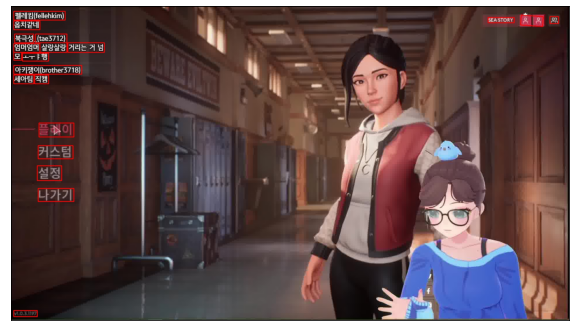

In [2]:
# CRAFT 결과 예시 이미지
# 빨강색 Box ==> 8개의 (x,y) 좌표
image = img.imread('./res_test-6112.jpg')

fig = plt.figure(figsize=(10,8))
ax = plt.gca()

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.imshow(image)
plt.show()

In [3]:
def find_txt(str_list): # .txt 파일 찾아주는 함수
    txt_list = []
    for str in str_list:
        if str[-4:] == '.txt':
            txt_list.append(str)
    return txt_list

def height_width_conversion(eight_list): # 좌표 8개를 받아서 [높이, 너비]로 바꿔주는 함수
    height = int(eight_list[-1])
    width = np.abs(int(eight_list[-2]) - int(eight_list[-4]))
    return [height, width]

In [4]:
#data folder에 "세아스토리" 유튜브 영상 문자 인식 딥러닝 결과 자료
#text file 불러오기
all_files = os.listdir("./data/")

txt_files = find_txt(all_files)

txt_list = []
for txt_f in txt_files: 
    with open(f"./data/{txt_f}", "r") as file:
        strings =  file.readlines()
        txt_list.append(strings)

In [5]:
md_txt = [] #modified text: text file name 전처리하기
for txt in txt_list:
    md_txt_s = []
    for b in txt:
        bbox = b.split(',')
        last = bbox.pop()
        bbox.append(last.replace('\n', ''))
        md_txt_s.append(bbox)
    md_txt.append(md_txt_s)

In [17]:
hwty_list = [] # 8개의 Bounding Box (x,y)값 ==> (height, width, time(1fps), left_upper_y)
time = 0
for txt in md_txt:
    time += 1
    hwty_list_s = []
    for b in txt:
        hwty = height_width_conversion(b)
        hwty.append(time)
        hwty.append(int(b[1]))
        hwty_list_s.append(hwty)
    hwty_list.append(hwty_list_s)

In [18]:
hwty_list #각 채팅 box에 대해 [높이, 너비, 시간(1fps), 좌측 상단 y값]

[[[33, 27, 1, 15],
  [60, 39, 1, 27],
  [57, 15, 1, 30],
  [61, 59, 1, 41],
  [57, 36, 1, 36],
  [78, 54, 1, 57],
  [88, 53, 1, 60],
  [84, 42, 1, 63],
  [93, 78, 1, 69],
  [108, 69, 1, 87],
  [120, 81, 1, 93],
  [127, 64, 1, 102],
  [147, 15, 1, 123],
  [150, 51, 1, 123],
  [178, 67, 1, 155],
  [507, 123, 1, 477],
  [537, 70, 1, 506],
  [537, 48, 1, 510],
  [540, 114, 1, 510],
  [537, 45, 1, 510],
  [687, 102, 1, 651],
  [1076, 270, 1, 938],
  [1076, 372, 1, 944],
  [1041, 36, 1, 1020]],
 [[33, 27, 2, 15],
  [60, 39, 2, 27],
  [57, 18, 2, 30],
  [60, 59, 2, 40],
  [57, 36, 2, 36],
  [82, 56, 2, 59],
  [88, 53, 2, 60],
  [84, 42, 2, 63],
  [93, 75, 2, 69],
  [108, 69, 2, 87],
  [120, 81, 2, 93],
  [127, 64, 2, 101],
  [147, 15, 2, 123],
  [150, 54, 2, 123],
  [178, 67, 2, 155],
  [507, 120, 2, 477],
  [537, 114, 2, 506],
  [537, 69, 2, 507],
  [537, 45, 2, 510],
  [537, 45, 2, 510],
  [687, 102, 2, 651],
  [963, 27, 2, 927],
  [1077, 273, 2, 939],
  [1076, 375, 2, 941],
  [1041, 36, 2,

In [12]:
h_list = []
for frame in hwty_list:
    for bbox in frame:
        h_list.append(bbox[0])

#전체 영상에 대해 채팅창이 움직이지 않았다는 가정 하에, 채팅창 총 높이 = max_distance
maximum_distance = max(h_list) - min(h_list)

In [14]:
for f_box in hwty_list[0]: # f_box: first_box, 즉 현재 프레임의 box
    print(f_box[1])

27
39
15
59
36
54
53
42
78
69
81
64
15
51
67
123
70
48
114
45
102
270
372
36


In [15]:
for s_box in hwty_list[1]: # s_box: second_box, 즉 다음 프레임의 box
    print(s_box[1])

27
39
18
59
36
56
53
42
75
69
81
64
15
54
67
120
114
69
45
45
102
27
273
375
36


### - 1st problem
- width를 Bounding Box의 ID로 사용하면서, 위의 경우 45-bbox가 여러개 있기에 중복 탐색이 발생한다.

### - 1st Solution
- 박스 이전, 이후의 width를 함께 비교 대조하여, 중복을 걸러내도록 한다.

In [49]:
for a, b, c, x, y, z in zip(hwt_list[0][:-2], hwt_list[0][1:-1], hwt_list[0][2:], hwt_list[1][:-2], hwt_list[1][1:-1], hwt_list[1][2:]): #이전 box, 현재 box, 다음 box
    print(a, b, c, x, y, z) # width가 45인 경우가 두번 중복되는 경우 발생.

[33, 27, 1] [60, 39, 1] [57, 15, 1] [33, 27, 2] [60, 39, 2] [57, 18, 2]
[60, 39, 1] [57, 15, 1] [61, 59, 1] [60, 39, 2] [57, 18, 2] [60, 59, 2]
[57, 15, 1] [61, 59, 1] [57, 36, 1] [57, 18, 2] [60, 59, 2] [57, 36, 2]
[61, 59, 1] [57, 36, 1] [78, 54, 1] [60, 59, 2] [57, 36, 2] [82, 56, 2]
[57, 36, 1] [78, 54, 1] [88, 53, 1] [57, 36, 2] [82, 56, 2] [88, 53, 2]
[78, 54, 1] [88, 53, 1] [84, 42, 1] [82, 56, 2] [88, 53, 2] [84, 42, 2]
[88, 53, 1] [84, 42, 1] [93, 78, 1] [88, 53, 2] [84, 42, 2] [93, 75, 2]
[84, 42, 1] [93, 78, 1] [108, 69, 1] [84, 42, 2] [93, 75, 2] [108, 69, 2]
[93, 78, 1] [108, 69, 1] [120, 81, 1] [93, 75, 2] [108, 69, 2] [120, 81, 2]
[108, 69, 1] [120, 81, 1] [127, 64, 1] [108, 69, 2] [120, 81, 2] [127, 64, 2]
[120, 81, 1] [127, 64, 1] [147, 15, 1] [120, 81, 2] [127, 64, 2] [147, 15, 2]
[127, 64, 1] [147, 15, 1] [150, 51, 1] [127, 64, 2] [147, 15, 2] [150, 54, 2]
[147, 15, 1] [150, 51, 1] [178, 67, 1] [147, 15, 2] [150, 54, 2] [178, 67, 2]
[150, 51, 1] [178, 67, 1] [507, 12

In [47]:
# 이전, 지금, 이후 box를 비교한다.
for fb_box, f_box, fa_box in zip(hwt_list[0][:-2], hwt_list[0][1:-1], hwt_list[0][2:]): 
        for sb_box, s_box, sa_box in zip(hwt_list[1][:-2], hwt_list[1][1:-1], hwt_list[1][2:]):
            if (f_box[1] == s_box[1]) & ( (fb_box[1] == sb_box[1]) | (fa_box[1] == sa_box[1]) ):
                print((fb_box, f_box, fa_box), (sb_box, s_box, sa_box)
# width가 45로 중복된 것을 걸러내는 데 성공했다. (검증 완료.)

([33, 27, 1], [60, 39, 1], [57, 15, 1]) ([33, 27, 2], [60, 39, 2], [57, 18, 2])
([57, 15, 1], [61, 59, 1], [57, 36, 1]) ([57, 18, 2], [60, 59, 2], [57, 36, 2])
([61, 59, 1], [57, 36, 1], [78, 54, 1]) ([60, 59, 2], [57, 36, 2], [82, 56, 2])
([78, 54, 1], [88, 53, 1], [84, 42, 1]) ([82, 56, 2], [88, 53, 2], [84, 42, 2])
([88, 53, 1], [84, 42, 1], [93, 78, 1]) ([88, 53, 2], [84, 42, 2], [93, 75, 2])
([93, 78, 1], [108, 69, 1], [120, 81, 1]) ([93, 75, 2], [108, 69, 2], [120, 81, 2])
([108, 69, 1], [120, 81, 1], [127, 64, 1]) ([108, 69, 2], [120, 81, 2], [127, 64, 2])
([120, 81, 1], [127, 64, 1], [147, 15, 1]) ([120, 81, 2], [127, 64, 2], [147, 15, 2])
([127, 64, 1], [147, 15, 1], [150, 51, 1]) ([127, 64, 2], [147, 15, 2], [150, 54, 2])
([540, 114, 1], [537, 45, 1], [687, 102, 1]) ([537, 45, 2], [537, 45, 2], [687, 102, 2])
([537, 45, 1], [687, 102, 1], [1076, 270, 1]) ([537, 45, 2], [687, 102, 2], [963, 27, 2])


In [20]:
max_d = maximum_distance #채팅방 전체 높이로 나누어 Normalization 할 것. 

v_list = []
for fr_num in range(len(hwty_list)-1):
    v_list_s=[] #프레임 당 초기화
    for fb_box, f_box, fa_box in zip(hwty_list[fr_num][:-2], hwty_list[fr_num][1:-1], hwty_list[fr_num][2:]): # 이전, 지금, 이후 box
        for sb_box, s_box, sa_box in zip(hwty_list[fr_num+1][:-2], hwty_list[fr_num+1][1:-1], hwty_list[fr_num+1][2:]):
            if (f_box[1] == s_box[1]) & ( (fb_box[1] == sb_box[1]) | (fa_box[1] == sa_box[1]) ): #지금 width는 같고, 이전과 이후 중 1개만 같으면 통과 
                distance = np.abs(s_box[3] - f_box[3]) +1 #1은 margin distance가 0이 되는 경우
                velocity = distance / (s_box[2] - f_box[2]) 
                normalized_v = velocity / max_d
                v_list_s.append(normalized_v)
            else:
                pass #탐색하지 못하는 경우
#                 v_list_s.append(1/max_d) #같은 박스를 찾지 못한 경우, 최솟값 1/max_d값을 넣는 경우를 고려한다.
    v_list.append(np.mean(v_list_s)) #1 프레임의 모든 box에 대해 평균

In [21]:
1 / maximum_distance # 속도의 최솟값

0.0009398496240601503

In [22]:
len(v_list) # 총 6113 frame의 데이터 중, 6112개의 프레임간 비교 값이 나왔다.

6112

### - 2st problem
- 영상의 특성 상, 탐색하지 못하는 시간 구간이 발생하게 되었다.

### - 2st Solution
- Character Recognition 뿐만 아니라, 영상의 소리 음성 인식을 추가 정보로 고려하도록 한다.

In [23]:
v_list #탐색하지 못하는 경우 nan으로 출력.

[0.0011107313738892685,
 nan,
 0.07048872180451128,
 0.0010964912280701754,
 0.0009398496240601503,
 0.0009398496240601503,
 0.09398496240601505,
 0.001029359112065879,
 0.07389567669172932,
 0.0011107313738892685,
 0.09962406015037593,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.04918546365914788,
 0.0009398496240601503,
 0.06156015037593985,
 0.06140350877192982,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.07424812030075188,
 0.027682843472317156,
 0.030263157894736836,
 0.02886680988184747,
 0.11528822055137845,
 0.023568536726431458,
 0.021952201933404938,
 0.03426179084073821,
 0.0009398496240601503,
 nan,
 nan,
 0.0010387811634349029,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 0.0009398496240601503,
 

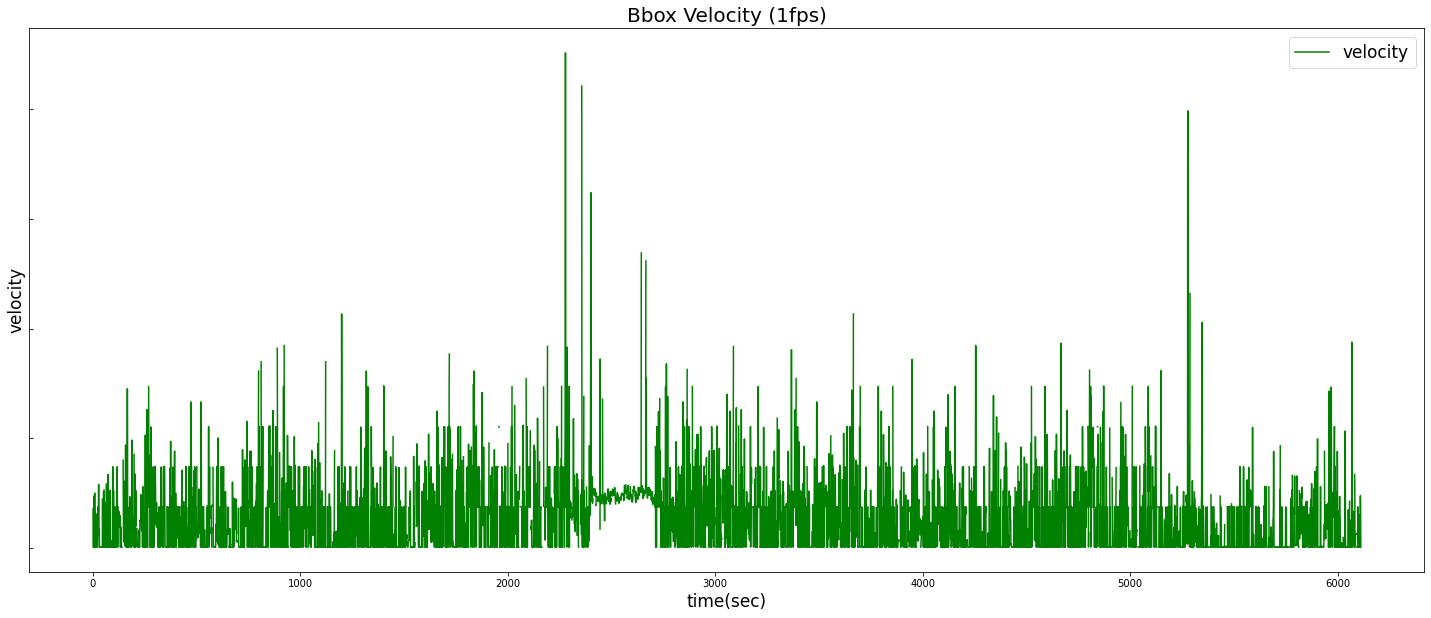

In [24]:
x_value = range(len(v_list))
y_value = v_list

fig = plt.figure(figsize=(25,10))

fig.patch.set_facecolor('xkcd:white')
# plt.style.use('default')

plt.plot(x_value, y_value, 'g-', label = 'velocity')
plt.legend(prop={'size':17})
plt.title("Bbox Velocity (1fps)", fontdict={'fontsize': 20})

plt.xlabel('time(sec)', fontdict={'fontsize': 17})
plt.ylabel('velocity', fontdict={'fontsize': 17})

plt.tick_params(axis='y', direction = 'in', labelleft = False)

plt.show()

## frame 묶어서 단순화하기
- 1분 단위로 채팅방 속도 변화를 탐색해보자. (아래 n 값에 60을 넣는다.)
    - nan 값을 처리하지 않아, 아래 묶은 그래프는 그리지 못함. -> 먼저, nan값을 전처리 할 필요가 있음.

In [29]:
n = 60 # n개의 묶음으로 평균 꺽은선 그래프를 그려보자 

result_mean = [np.mean(v_list[i * n:(i + 1) * n]) for i in range((len(v_list) + n - 1) // n )]

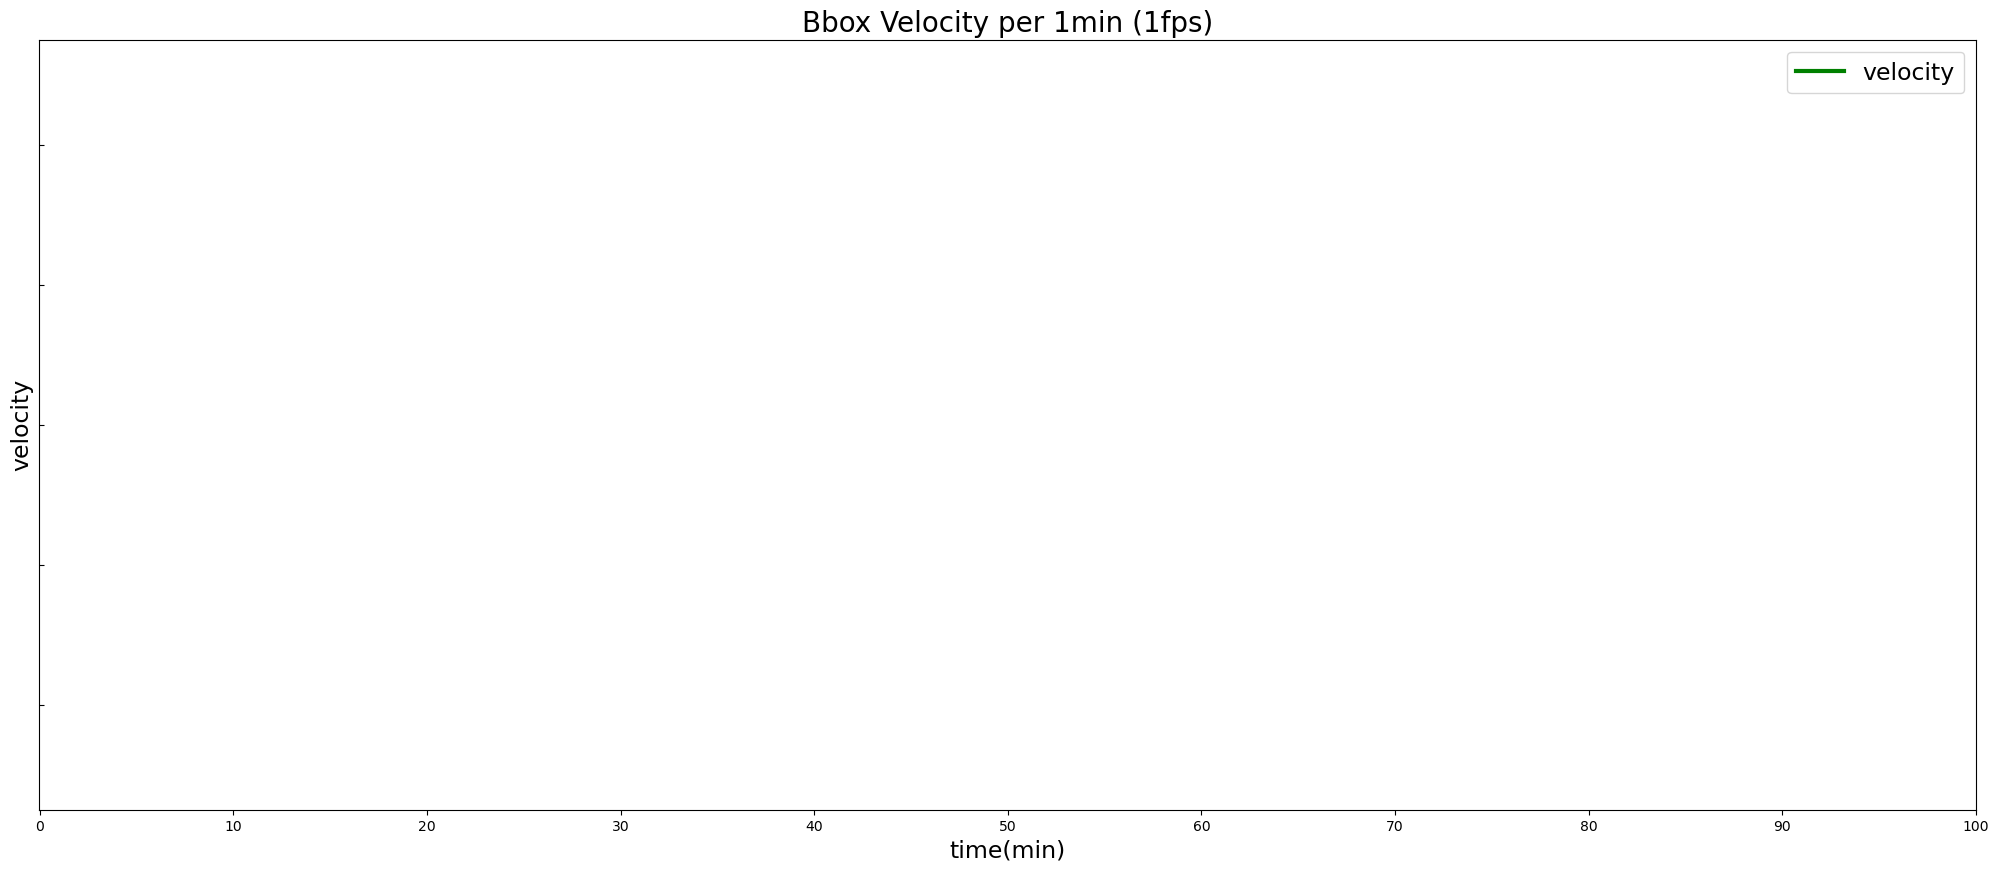

In [30]:
x_value = range(len(result_mean))
y_value = result_mean

fig = plt.figure(figsize=(25,10))

fig.patch.set_facecolor('xkcd:white')
plt.style.use('default')

plt.plot(x_value, y_value, 'g-', linewidth = 3, label = 'velocity')
plt.legend(loc = 'best', prop={'size':17})
plt.title("Bbox Velocity per 1min (1fps)", fontdict={'fontsize': 20})

plt.xlabel('time(min)', fontdict={'fontsize': 17})
plt.ylabel('velocity', fontdict={'fontsize': 17})

plt.xticks(range(0,100+1,10), fontsize = 10)
plt.tick_params(axis = 'y', direction = 'in', labelleft = False, grid_color='r')

plt.show()